tutorial: [Keyword Spotting](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [41]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython import display

from models import*

In [42]:
pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/kajaskramo/Documents/PU/DAT255/255-Project/venv/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [43]:
# DATASET_PATH = 'data/mini_speech_commands'

# data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'speech_commands.zip',
#       origin="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [44]:
data_dir = "../data/snake_commands"

In [45]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'left' 'up' 'down']


In [46]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 9454 files belonging to 4 classes.
Using 7564 files for training.
Using 1890 files for validation.

label names: ['down' 'left' 'right' 'up']


In [47]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [48]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [49]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [50]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [51]:
label_names[[1, 1, 3, 0]]

array(['left', 'left', 'up', 'down'], dtype='<U5')

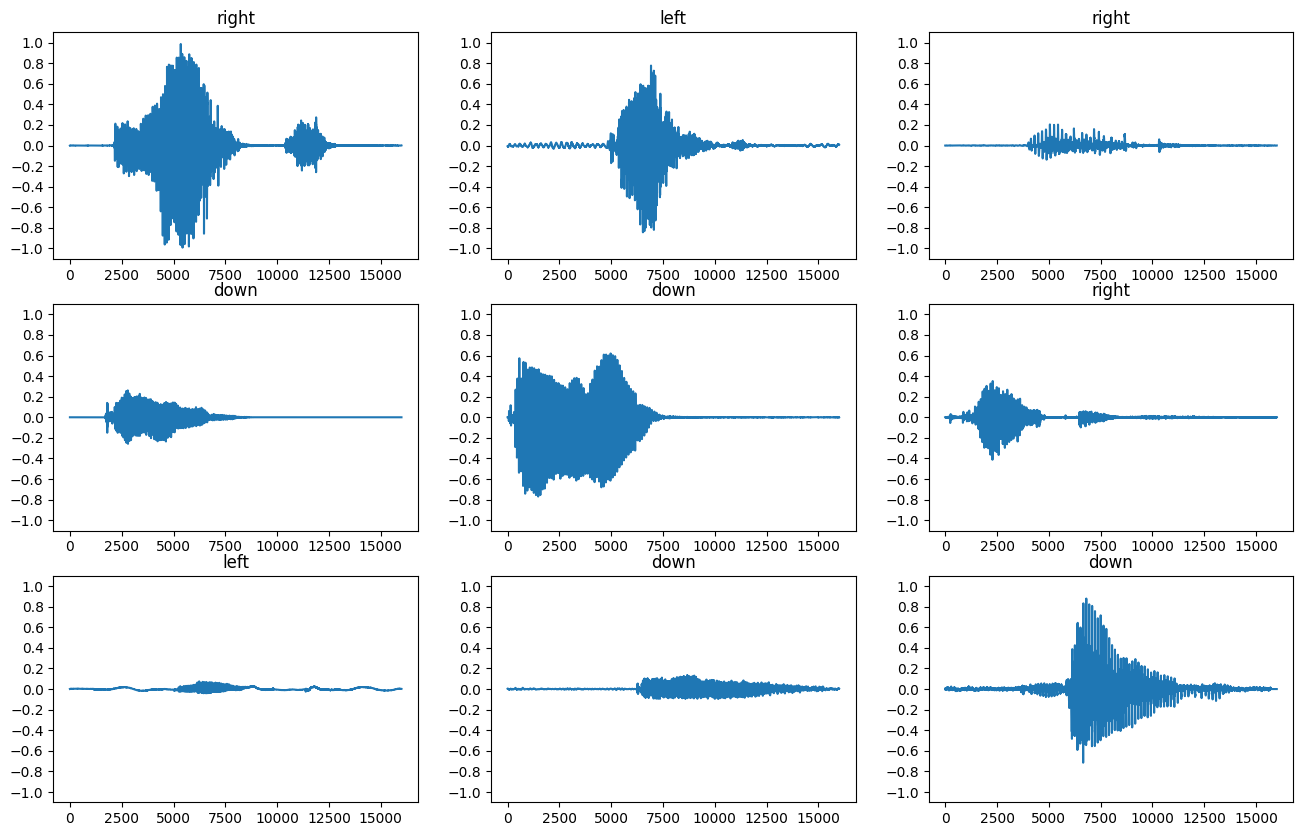

In [52]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [53]:
def get_spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [54]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectogram = get_spectogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectogram shape:', spectogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


In [55]:
def plot_spectogram(spectogram, ax):
    if len(spectogram.shape) > 2:
        assert len(spectogram.shape) == 3
        spectogram = np.squeeze(spectogram, axis=-1)

        log_spec = np.log(spectogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)

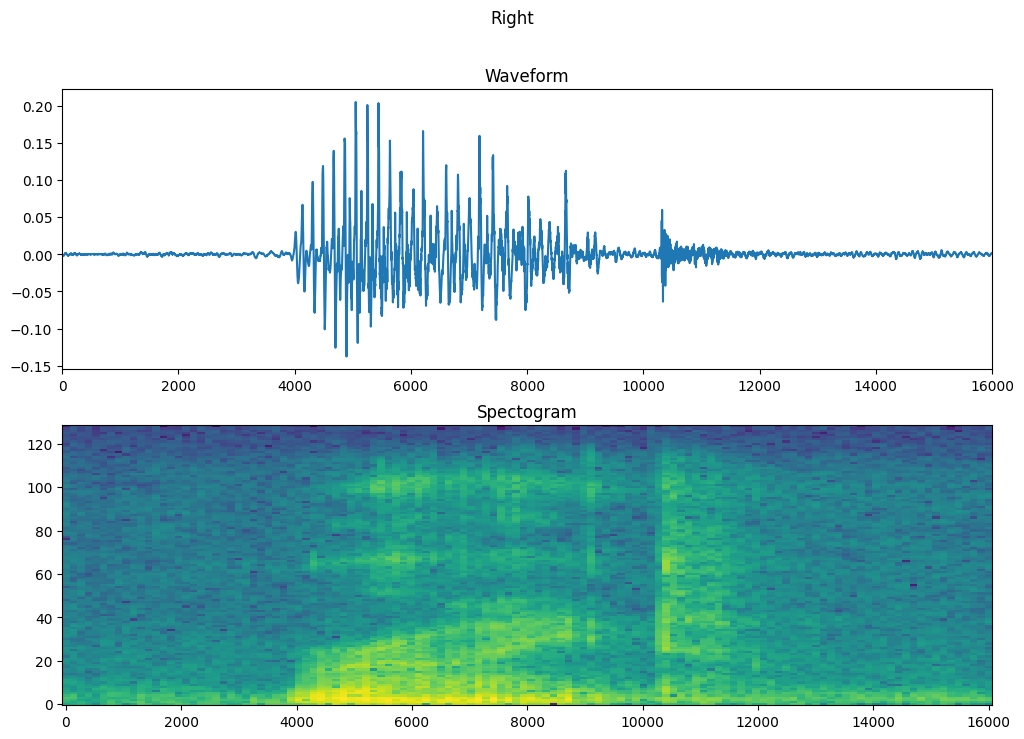

In [56]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectogram(spectogram.numpy(), axes[1])
axes[1].set_title('Spectogram')
plt.suptitle(label.title())
plt.show()

In [57]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [58]:
train_spectogram_ds = make_spec_ds(train_ds)
val_spectogram_ds = make_spec_ds(val_ds)
test_spectogram_ds = make_spec_ds(test_ds)

In [59]:
for example_spectograms, example_spect_labels in train_spectogram_ds.take(1):
    break

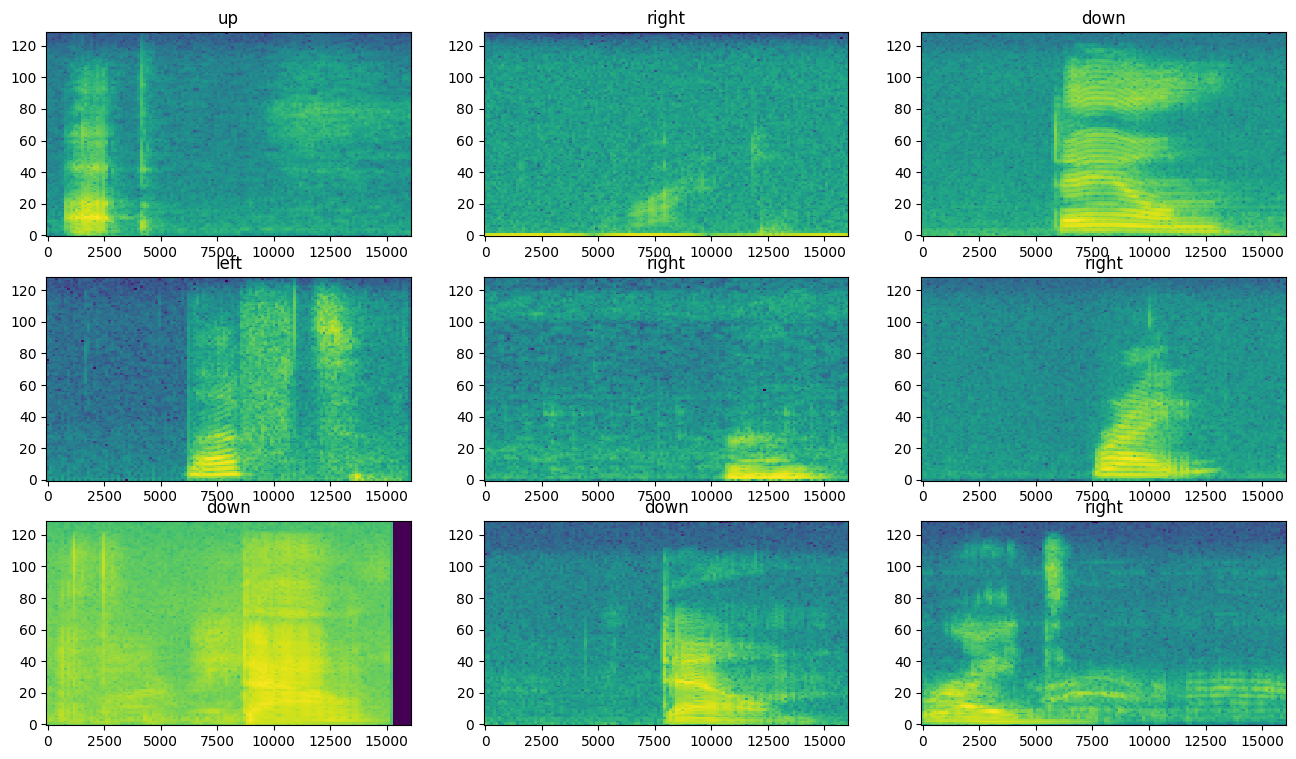

In [60]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectogram(example_spectograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [61]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [62]:
input_shape = example_spectograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectogram_ds.map(map_func=lambda spec, label: spec))

model = build_crnn_model(input_shape, num_labels, norm_layer)
model.summary()


# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     layers.Resizing(32, 32),
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels),
# ])

# model.summary()

Input shape: (124, 129, 1)


2025-04-09 14:01:00.986248: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


NameError: name 'build_crnn_model' is not defined

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_spectogram_ds,
    validation_data=val_spectogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9784 - loss: 0.0540 - val_accuracy: 0.9473 - val_loss: 0.2311
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9826 - loss: 0.0504 - val_accuracy: 0.9613 - val_loss: 0.1120
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9816 - loss: 0.0552 - val_accuracy: 0.9613 - val_loss: 0.1183
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9832 - loss: 0.0410 - val_accuracy: 0.9677 - val_loss: 0.0979
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9867 - loss: 0.0323 - val_accuracy: 0.9710 - val_loss: 0.1113
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9830 - loss: 0.0415 - val_accuracy: 0.9570 - val_loss: 0.1544
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9801 - loss: 0.0545 - val_accuracy: 0.9688 - val_loss: 0.1387
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9805 - loss: 0.0559 - val_accu

In [ ]:
model.save("voice_model.keras")

Text(0, 0.5, 'Accuracy [%]')

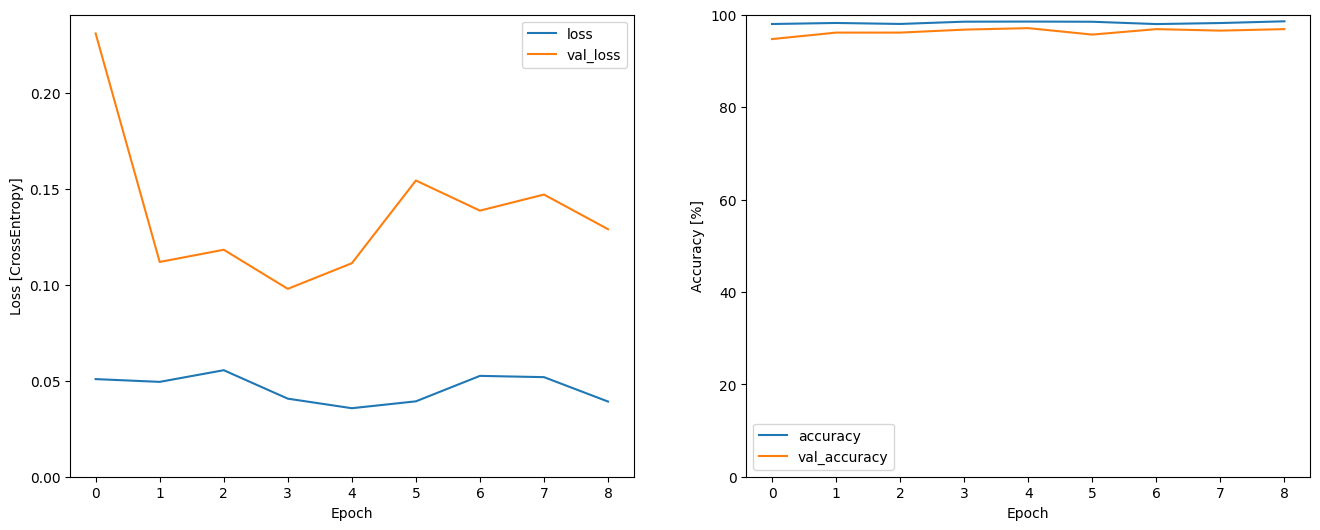

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectogram_ds, return_dict=True)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9591 - loss: 0.1467


{'accuracy': 0.956250011920929, 'loss': 0.1917734146118164}

In [ ]:
y_pred = model.predict(test_spectogram_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectogram_ds.map(lambda s, lab:lab)), axis=0)

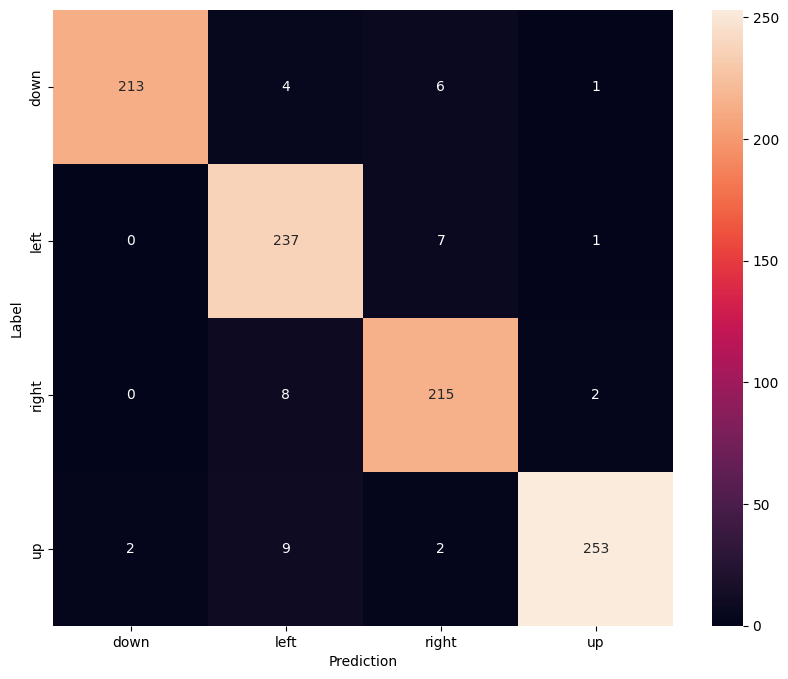

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from pathlib import Path

DATASET_PATH = "data/snake_commands"
data_dir = Path(DATASET_PATH)
file_path = data_dir / "up/0b40aa8e_nohash_0.wav"

print("File exists:", file_path.exists())  # Should print True or False
print("Full path:", file_path.resolve()) 

File exists: True
Full path: /Users/kajaskramo/Documents/DAT255/255-Project/data/snake_commands/up/0b40aa8e_nohash_0.wav


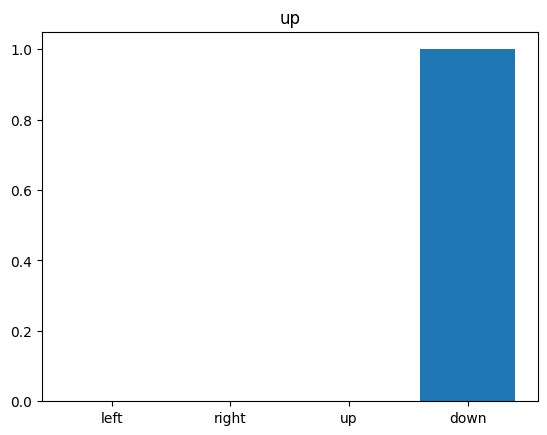

In [ ]:

x = data_dir/'up/0b40aa8e_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['left', 'right', 'up', 'down']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('up')
plt.show()

display.display(display.Audio(waveform, rate=16000))